In [154]:
%matplotlib inline

user-defined LaTeX commands
$\newcommand{\Er}{\mathcal{E}}$
$\newcommand{\Xset}{\mathcal{X}}$
$\newcommand{\Yset}{\mathcal{Y}}$
$\newcommand{\L}{\mathcal{L}}$
$\newcommand{\l}{\mathcal{l}}$
$\newcommand{\pr}{\mathbb{P}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\D}{\mathbb{D}}$
$\newcommand{\w}{\mathbf{w}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\J}{\mathbf{J}}$
$\newcommand{\I}{\mathbf{I}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\S}{\mathbf{S}}$
$\newcommand{\e}{\mathbf{e}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\R}{\mathbf{R}}$
$\newcommand{\v}{\mathbf{v}}$
$\newcommand{\phivec}{\boldsymbol{\phi}}$
$\newcommand{\sign}{\mathrm{sign}}$

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [156]:
from ggplot import *
from matplotlib import colors as clrs

In [157]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [158]:
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal

In [159]:
from matplotlib.colors import ListedColormap
import warnings
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

In [160]:
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import safe_sparse_dot
from sklearn.preprocessing import KernelCenterer

In [161]:
from scipy.spatial.distance import mahalanobis

In [162]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    n_class = len(np.unique(y))
    colors = list(clrs.cnames.keys())[:n_class]
    
    cmap = ListedColormap(colors[:n_class])
    # decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.xlim(xx2.min(), xx2.max())
    # plot samples
    X_test, y_test = X[test_idx,:], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), label=cl)
    # test samples highlight
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidth=1, s=55, label='test set')

### Toy data for classification task

In [163]:
X, y = make_blobs(centers=2, n_samples=1000)

In [164]:
X, y = make_moons(noise=0.1, n_samples=1000)

In [165]:
X = scale(X)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_train}

In [167]:
dat = pd.DataFrame(dat)
dat['color'] = ['red' if variable == 0 else 'blue' for variable in dat['variable']]

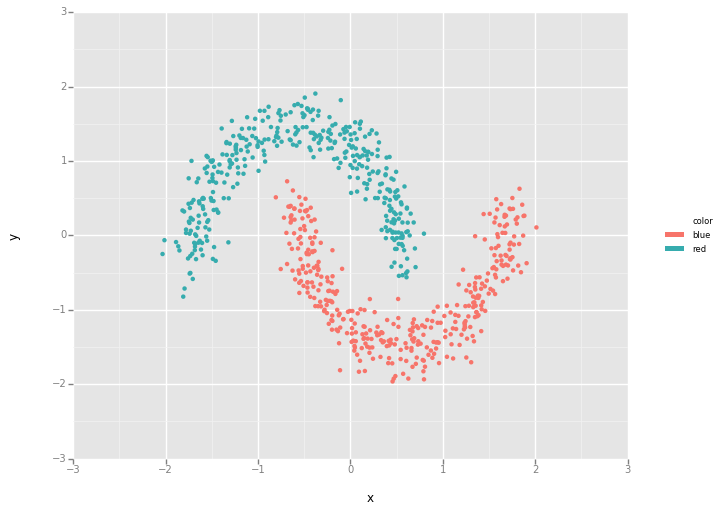

<ggplot: (-9223372036560081404)>

In [168]:
ggplot(aes(x='x', y='y', group='variable',color='color'),dat) + geom_point()

### Bayes Classifier
Let's look at the classification problem from probabilistic point of view. 

* Let $\mathbf{X}$ be a random vector, taken from a distribution with density function $p_{\mathbf{X}}$.
* Suppose that space, from wich $\mathbf{X}$ is drawn, is subdiveded into subspaces $\mathcal{H}_1$ and $\mathcal{H}_2$:
$\mathcal{H}_1\cap\mathcal{H}_2=\emptyset$ and $\mathcal{H}_1\cup\mathcal{H}_2=\mathcal{H}$.
* Subspaces $\mathcal{H}_i$ are represented by classes $\mathcal{C}_i$.
* Define **average risk**:
$$\mathcal{R}=c_{11}p_1\int_{\mathcal{H}_1}p_{\mathbf{X}}(\mathbf{x}|\mathcal{C}_1)d\mathbf{x} + 
c_{22}p_2\int_{\mathcal{H}_2}p_{\mathbf{X}}(\mathbf{x}|\mathcal{C}_2)d\mathbf{x} +
c_{21}p_1\int_{\mathcal{H}_2}p_{\mathbf{X}}(\mathbf{x}|\mathcal{C}_1)d\mathbf{x} + 
c_{12}p_2\int_{\mathcal{H}_1}p_{\mathbf{X}}(\mathbf{x}|\mathcal{C}_2)d\mathbf{x}$$
where
    * $p_i$ - is a *prior probability* that the observation $\mathbf{x}$ is drawn from $\mathcal{H}_i$, $p_1+p_2=1$;
    * $c_{ij}$ - is a cost of a decision in favor of class $i$, when class $j$ is actually true.

**Bayes classifier**
* Likelihood ratio: 
$$\displaystyle{\Lambda(\mathbf{x})=\frac{p_{\mathbf{X}}(\mathbf{x}|\mathcal{C}_1)}{p_{\mathbf{X}}(\mathbf{x}|\mathcal{C}_2)}}$$
* Threshold:
$$\displaystyle{\xi=\frac{p_2(c_{12}-c_{22})}{p_1(c_{21}-c_{11})}}$$
* Rule: *if for an observation $\x$ likelihood ratio $\Lambda(\x)>\xi$ assign $\x$ to class $\mathcal{C}_1$. Otherwise, assign $\x$ to class $\mathcal{C}_2$*

Log-likelihood ratio in Gaussian case:
$$\log\Lambda(\mathbf(x)=-\frac{1}{2}(\mathbf{x}-\mu_1)^T\mathbf{\Sigma}_1^{-1}(\mathbf{x}-\mu_1)+\frac{1}{2}(\mathbf{x}-\mu_2)^T\mathbf{\Sigma}_2^{-1}(\mathbf{x}-\mu_2)$$

In [169]:
def log_likelihood_ratio(x, mu, S):
    nominator = multivariate_normal.logpdf(x, mu[0], S[0])
    denominator = multivariate_normal.logpdf(x, mu[1], S[1])
    return nominator - denominator

**Relation between Bayes classifier and Perceptron**

* Let $\mathbf{\Sigma}_1=\mathbf{\Sigma}_2$, then $$\displaystyle{\log\Lambda(\mathbf{x})= (\mu_1-\mu_2)^T\mathbf{\Sigma}^{-1}\mathbf{x}+\frac{1}{2}\left(\mu_1^T\mathbf{\Sigma}^{-1}\mu_1 - \mu_2^T\mathbf{\Sigma}^{-1}\mu_2\right)}$$
and Bayes classifier can be written in linear form $\mathbf{y}=\mathbf{w}^T\mathbf{x}+b$, 
where
 * $\displaystyle{\mathbf{y}=\log\Lambda(\mathbf{x})}$;
 * $\displaystyle{\mathbf{w}=\mathbf{\Sigma}^{-1}(\mu_1-\mu_2)}$;
 * $\displaystyle{b=\frac{1}{2}\left(\mu_1^T\mathbf{\Sigma}^{-1}\mu_1 - \mu_2^T\mathbf{\Sigma}^{-1}\mu_2\right)}$

In [170]:
def step_function(x, margin=0, label=[0, 1]):
    return np.where(x >= margin, label[1], label[0])

In [172]:
class BayesClassifier(object):
    
    def __init__(self, n_class = 2):
        self.n_class_ = n_class
        self.threshold_ = 0.0
        
    def fit(self, X, y):
        labs = np.unique(y)
        self.n_class_ = len(labs)
        self.Ci_ = []
        self.Xi_ = []
        self.mu_ = []
        self.S_ = []
        self.p_ = []
        n_samples = X.shape[0]
        for i,lab in enumerate(labs):
            self.Ci_.append(list(np.where(y==lab)))
            self.Xi_.append(X[self.Ci_[i]])
            self.mu_.append(np.mean(self.Xi_[i],axis=0))
            self.S_.append(np.cov(self.Xi_[i].T[0],self.Xi_[i].T[1]))
            self.p_.append(len(self.Ci_[i][0])/n_samples)
        self.threshold_ = np.log(self.p_[0]) - np.log(self.p_[1])
        return self
    
    def predict(self, X):
        self.llr_ = []
        n_samples = X.shape[0]
        y = np.zeros(n_samples)
        for i,x in enumerate(X):
            r = log_likelihood_ratio(x, self.mu_, self.S_)
            y[i] = step_function(r,self.threshold_,[1,0])
            self.llr_.append(r)
        self.llr_ = np.array(self.llr_)
        self.y_ = y.astype(int)
        return self.y_
    
    def score(self, X, y):
        return (self.predict(X) == y).astype(float).sum() / len(y)

In [173]:
clf = BayesClassifier()
clf.fit(X_train, y_train)
print('Train score %.3f, Test score %.3f' % (clf.score(X_train, y_train), clf.score(X_test, y_test)))

Train score 0.883, Test score 0.900


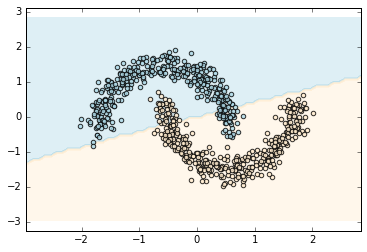

In [174]:
plot_decision_regions(X_train, y_train, clf, resolution=0.1)

### Multi-class Bayes Classifier (Gaussian case)
Suppose number of classes we want to attribute observations is greater than 2. How can we use Bayes procedure to solve the problem? 

In [185]:
n_centers = 3

In [186]:
X, y = make_blobs(centers=n_centers, n_samples=1000, cluster_std=1)

In [187]:
X = scale(X)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dat = {'x': X_train.T[0], 'y': X_train.T[1], 'variable': y_train}

In [189]:
dat = pd.DataFrame(dat)
#colors = {0:'red',1:'blue',2:'green'}
colors = dict(zip(np.arange(n_centers),list(clrs.cnames.keys())[:n_centers]))
dat['color'] = [colors[variable] for variable in dat['variable']]

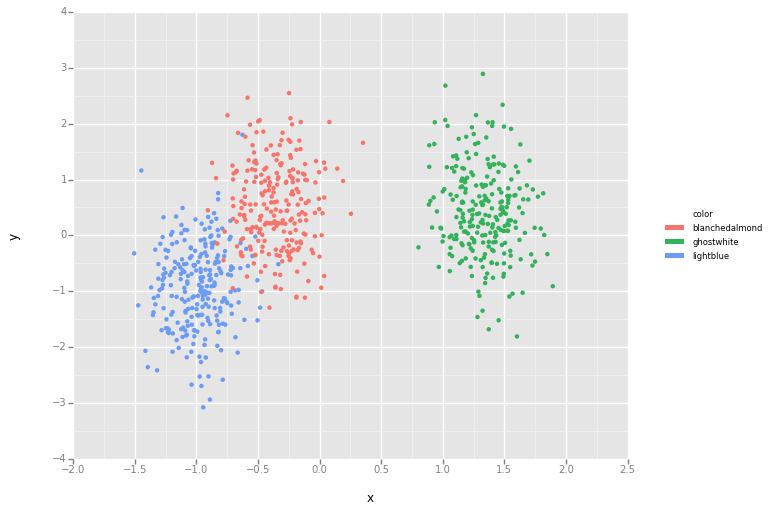

<ggplot: (-9223372036560184334)>

In [190]:
ggplot(aes(x='x', y='y', group='variable',color='color'),dat) + geom_point()

* Log-likelihood for the $k$-th calss will take the form 
$$\displaystyle{-\mathcal{l}_k(\mathbf{x}|\mathcal{C}_k)=\delta_k(\mathbf{x})=\mathbf{x}^T\mathbf{\Sigma}_k^{-1}\mu_k-\frac{1}{2}\mu_k^T\mathbf{\Sigma}_k^{-1}\mu_k+\log p_k,}$$ where $\sum_{k=1}^Kp_k=1$, $K$ - total number of classes.
* We'll assign $\mathbf{x}$ class, for which $\delta_k(\mathbf{x})$ is largest.

In [191]:
def class_log_likelihood(x, mu, S, p):
    n_class = len(mu)
    delta = []
    for mu_,S_,p_ in zip(mu,S,p):
        delta.append(multivariate_normal.logpdf(x, mu_, S_) + np.log(p_))
    return delta

In [195]:
class MulticlassBayesClassifier(object):
    
    def __init__(self, n_class = 2):
        self.n_class_ = n_class
        
    def fit(self, X, y):
        labs = np.unique(y)
        self.n_class_ = len(labs)
        self.Ci_ = []
        self.Xi_ = []
        self.mu_ = []
        self.S_ = []
        self.p_ = []
        n_samples = X.shape[0]
        for i,lab in enumerate(labs):
            self.Ci_.append(list(np.where(y==lab)))
            self.Xi_.append(X[self.Ci_[i]])
            self.mu_.append(np.mean(self.Xi_[i],axis=0))
            self.S_.append(np.cov(self.Xi_[i].T))
            self.p_.append(len(self.Ci_[i][0])/n_samples)
        return self
    
    def predict(self, X):
        self.llr_ = []
        n_samples = X.shape[0]
        y = np.zeros(n_samples)
        for i,x in enumerate(X):
            delta = class_log_likelihood(x, self.mu_, self.S_, self.p_)
            y[i] = delta.index(max(delta))
            self.llr_.append(delta)
        self.y_ = y.astype(int)
        return self.y_
    
    def score(self, X, y):
        return (self.predict(X) == y).astype(float).sum() / len(y)

In [193]:
clf = MulticlassBayesClassifier()
clf.fit(X_train, y_train)
print('Train score %.3f, Test score %.3f' % (clf.score(X_train, y_train), clf.score(X_test, y_test)))

Train score 0.973, Test score 0.964


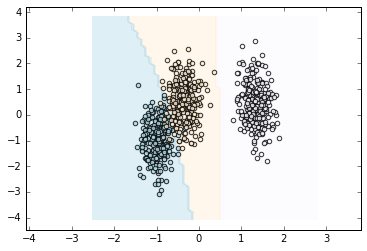

In [194]:
plot_decision_regions(X_train, y_train, clf, resolution = 0.1)

### MNIST dataset for classification

**Bayes classifier**
* Denote $\displaystyle{f_k(X)=\pr\left(X=x\thinspace | \thinspace \mathcal{C}_k\right)}$
* Let $\pi_k(x)$ be the prior probability of class $k$
* From Bayes theorem: $$\displaystyle{\pr\left(\mathcal{C}_k\thinspace | \thinspace X=x\right)=\frac{\pi_kf_k(x)}{\sum_{j=1}^K\pi_j f_j(x)}}$$
* Assign $x$ to the class, for which posterior probability is the biggest one.

**Multinomial Bayes classificator**

* Probability of events $(p_1,\ldots,p_m)$ for feature vector $\x=(x_1,\ldots,x_m)$, which can be intrepreted as a histogram.
* Likelihood of observing $\x$: $$\displaystyle{\pr(X \thinspace | \thinspace \mathcal{C}_k)=\frac{\left(\sum_i x_i\right)!}{\prod x_i!}\prod_ip_{k_i}^{x_i}}$$ 
* Log-posterior: $$\displaystyle{\log \pr\left(\mathcal{C}_k\thinspace | \thinspace \x\right)\propto\log \left(\pr(\mathcal{C}_k)\prod_{i}p_{k_i}^{x_i} \right)=\log\pr(\mathcal{C}_k)+\sum_ix_i\cdot\log p_{k_i}=\mathbf{b}+\w^T\x,}$$
where
    * $\mathbf{b}=\log\pr(\mathcal{C}_k)$
    * $\w_{k_i}=\log p_{k_i}$

In [209]:
from sklearn.datasets import load_digits

In [210]:
digits = load_digits()

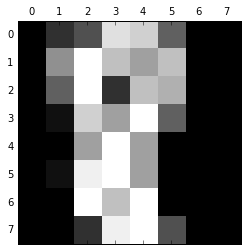

In [199]:
plt.gray() 
plt.matshow(digits.images[76]) 
plt.show(); 

In [211]:
n_samples = len(digits.images)

In [212]:
X, y = digits.images.reshape(n_samples, -1), digits.target

In [204]:
np.max(X)

16.0

In [203]:
X[0].reshape(8,8)

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]])

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

$$\displaystyle{\log \pr\left(\mathcal{C}_k\thinspace | \thinspace \x\right)\propto\log \left(\pr(\mathcal{C}_k)\prod_{i}p_{k_i}^{x_i} \right)=\log\pr(\mathcal{C}_k)+\sum_ix_i\cdot\log p_{k_i}=\mathbf{b}+\w^T\x,}$$

In [205]:
def multinom_log_likelihood(x, pi, p, eps = 0.01):
    n_class = len(pi)
    delta = []
    for pi_, p_ in zip(pi, p):
        loglik = np.log(pi_ + eps) + np.dot(x, np.log(p_ + eps))
        delta.append(loglik)
    return delta

In [207]:
class MultinomialBayesClassifier(object):
    
    def __init__(self, n_class = 2):
        self.n_class_ = n_class
        
    def fit(self, X, y):
        labs = np.unique(y)
        self.n_class_ = len(labs)
        self.Ci_ = []
        self.Xi_ = []
        self.pi_ = []
        self.p_ = []
        n_max = np.max(X)
        n_samples = X.shape[0]
        for i,lab in enumerate(labs):
            self.Ci_.append(list(np.where(y==lab)))
            self.Xi_.append(X[self.Ci_[i]])
            self.pi_.append(len(self.Ci_[i][0])/n_samples)
            p = np.mean(self.Xi_[i], axis=0)/n_max
            self.p_.append(p)
        return self
    
    def predict(self, X):
        self.llr_ = []
        n_samples = X.shape[0]
        y = np.zeros(n_samples)
        for i,x in enumerate(X):
            delta = multinom_log_likelihood(x, self.pi_, self.p_)
            y[i] = delta.index(max(delta))
            self.llr_.append(delta)
        self.y_ = y.astype(int)
        return self.y_
    
    def score(self, X, y):
        return (self.predict(X) == y).astype(float).sum() / len(y)

In [214]:
clf = MultinomialBayesClassifier()
clf.fit(X_train, y_train)
print('Train score %.3f, Test score %.3f' % (clf.score(X_train, y_train), clf.score(X_test, y_test)))

Train score 0.869, Test score 0.880


### Examples of failures

Obtain predicted labels:

In [215]:
y_pred = clf.predict(X_test)

List of failure indices

In [217]:
idx = np.arange(len(y_test))
idx = idx[y_test != y_pred]

In [218]:
failure_images = X_test[idx]
failure_labels = y_test[idx]
failure_output = y_pred[idx]

Actual digit 9, Predicted label 7


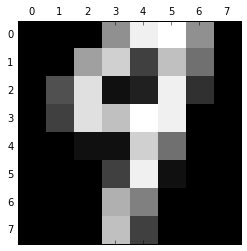

In [221]:
i = 1
image = failure_images[i].reshape(8, 8)
digit = failure_labels[i]
label = failure_output[i]

print('Actual digit %d, Predicted label %d' % (digit, label))
plt.gray() 
plt.matshow(image); 